# Librerie

In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
import scipy.optimize as opt

# Caricamento Dati

In [260]:
options_3 = pd.read_csv('2013-01/2013-01-03options.csv')
options_4 = pd.read_csv('2013-01/2013-01-04options.csv')

stocks_3 = pd.read_csv('2013-01/2013-01-03stocks.csv')
stocks_4 = pd.read_csv('2013-01/2013-01-04stocks.csv')

display(options_4)
display(stocks_4)

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,volume,open_interest,quote_date,delta,gamma,theta,vega,implied_volatility
0,A130119C00018000,A,2013-01-19,call,18.0,A,23.35,NaN,26.40,NaN,0,0,2013-01-04,1.0000,0.0000,-0.0545,0.0000,0.2540
1,A130119P00018000,A,2013-01-19,put,18.0,A,0.00,NaN,0.02,NaN,0,215,2013-01-04,0.0000,0.0000,0.0000,0.0000,0.3212
2,A130119C00019000,A,2013-01-19,call,19.0,A,22.35,NaN,25.45,NaN,0,0,2013-01-04,1.0000,0.0000,-0.0575,0.0000,0.2540
3,A130119P00019000,A,2013-01-19,put,19.0,A,0.00,NaN,0.02,NaN,0,4,2013-01-04,0.0000,0.0000,0.0000,0.0000,0.3212
4,A130119C00020000,A,2013-01-19,call,20.0,A,21.15,NaN,24.40,NaN,0,5,2013-01-04,1.0000,0.0000,-0.0606,0.0000,0.2540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513708,ZX130622P00002500,ZX,2013-06-22,put,2.5,A,0.10,NaN,0.50,NaN,0,0,2013-01-04,-0.2520,0.2137,-0.5283,0.6657,0.7076
513709,ZX130622C00005000,ZX,2013-06-22,call,5.0,A,0.00,NaN,0.25,NaN,0,0,2013-01-04,0.1948,0.1946,-0.4041,0.5754,0.6713
513710,ZX130622P00005000,ZX,2013-06-22,put,5.0,A,1.85,NaN,2.30,NaN,0,0,2013-01-04,-0.7846,0.1950,-0.4906,0.5900,0.6870
513711,ZX130622C00007500,ZX,2013-06-22,call,7.5,A,0.00,NaN,0.25,NaN,0,0,2013-01-04,0.1527,0.1143,-0.5119,0.4930,0.9794


,symbol,open,high,low,close,volume,adjust_close
0,A,42.139999,42.949999,41.860001,42.860000,6432800,NaN
1,AA,9.109990,9.279990,9.099990,9.259991,6115100,NaN
2,AACC,4.800000,4.805000,4.630000,4.720000,22400,NaN
3,AAMRQ,0.840000,0.880000,0.830000,0.870000,2680100,NaN
4,AAN,28.820000,29.290001,28.719999,29.110001,251500,NaN
...,...,...,...,...,...,...,...
3801,WCBO,22.790000,22.980000,22.770000,22.890000,92100,NaN
3802,XAL,47.490000,47.490000,47.490000,47.490000,0,NaN
3803,XRM,3.270000,3.650000,3.250000,3.600000,56300,NaN
3804,YRCW,6.780000,6.920000,6.650000,6.670000,83900,NaN


In [261]:
spx_option_3 = options_3[options_3['underlying']=='SPX']
spx_option_4 = options_4[options_4['underlying']=='SPX']

spx_option_3 = spx_option_3[spx_option_3['type']=='call']
spx_option_4 = spx_option_4[spx_option_4['type']=='call']

spx_option_3 = spx_option_3[spx_option_3['style']=='E']
spx_option_4 = spx_option_4[spx_option_4['style']=='E']

spx_option_3 = spx_option_3[['underlying','expiration', 'strike','bid','ask','quote_date','implied_volatility']]
spx_option_4 = spx_option_4[['underlying','expiration', 'strike','bid','ask','quote_date','implied_volatility']]


spx_option_3['expiration'] = pd.to_datetime(spx_option_3['expiration'])
spx_option_3['quote_date'] = pd.to_datetime(spx_option_3['quote_date'])
spx_option_4['expiration'] = pd.to_datetime(spx_option_4['expiration'])
spx_option_4['quote_date'] = pd.to_datetime(spx_option_4['quote_date'])

spx_option_3['ttm'] = ((spx_option_3['expiration'] - spx_option_3['quote_date']).dt.days / 365.25).round(3)
spx_option_4['ttm'] = ((spx_option_4['expiration'] - spx_option_4['quote_date']).dt.days / 365.25).round(3)

spx_option_3['price'] = (spx_option_3['bid']+spx_option_3['ask'])/2
spx_option_4['price'] = (spx_option_4['bid']+spx_option_4['ask'])/2

spx_option_3 = spx_option_3[spx_option_3['price']>1]
spx_option_4 = spx_option_4[spx_option_4['price']>1]

spx_option_3.rename(columns={'underlying': 'symbol'}, inplace=True)
spx_option_4.rename(columns={'underlying': 'symbol'}, inplace=True)

spx_stocks_3 = stocks_3[stocks_3['symbol']=='SPX']
spx_stocks_4 = stocks_4[stocks_4['symbol']=='SPX']

spx_option_3 = spx_option_3.merge(
    spx_stocks_3[['symbol','close']],  # Seleziona solo le colonne necessarie
    left_on=['symbol'],        # Colonne del dataset delle opzioni
    right_on=['symbol'],             # Colonne del dataset del sottostante
    how='left'  # Mantieni tutte le opzioni e unisci solo i prezzi disponibili
)
spx_option_4 = spx_option_4.merge(
    spx_stocks_4[['symbol','close']],  # Seleziona solo le colonne necessarie
    left_on=['symbol'],        # Colonne del dataset delle opzioni
    right_on=['symbol'],             # Colonne del dataset del sottostante
    how='left'  # Mantieni tutte le opzioni e unisci solo i prezzi disponibili
)


spx_option_3.rename(columns={'close': 's0'}, inplace=True)
spx_option_3['price_s'] = spx_option_3['price']/spx_option_3['s0']
spx_option_4.rename(columns={'close': 's0'}, inplace=True)
spx_option_4['price_s'] = spx_option_4['price']/spx_option_4['s0']

display(spx_option_3)
display(spx_option_4)

,symbol,expiration,strike,bid,ask,quote_date,implied_volatility,ttm,price,s0,price_s
0,SPX,2013-01-04,1100.0,357.30,359.5,2013-01-03,0.3154,0.003,358.400,1459.369995,0.245585
1,SPX,2013-01-04,1125.0,332.30,334.5,2013-01-03,0.3154,0.003,333.400,1459.369995,0.228455
2,SPX,2013-01-04,1150.0,307.30,309.5,2013-01-03,0.3154,0.003,308.400,1459.369995,0.211324
3,SPX,2013-01-04,1175.0,282.30,284.5,2013-01-03,0.3154,0.003,283.400,1459.369995,0.194193
4,SPX,2013-01-04,1180.0,277.30,279.5,2013-01-03,0.3154,0.003,278.400,1459.369995,0.190767
...,...,...,...,...,...,...,...,...,...,...,...
837,SPX,2015-12-19,2100.0,10.50,12.6,2013-01-03,0.1368,2.957,11.550,1459.369995,0.007914
838,SPX,2015-12-19,2200.0,6.50,7.6,2013-01-03,0.1351,2.957,7.050,1459.369995,0.004831
839,SPX,2015-12-19,2250.0,5.20,6.1,2013-01-03,0.1354,2.957,5.650,1459.369995,0.003872
840,SPX,2015-12-19,2500.0,2.50,2.6,2013-01-03,0.1429,2.957,2.550,1459.369995,0.001747


,symbol,expiration,strike,bid,ask,quote_date,implied_volatility,ttm,price,s0,price_s
0,SPX,2013-01-04,1100.0,364.60,367.60,2013-01-04,0.3000,0.000,366.100,1466.469971,0.249647
1,SPX,2013-01-04,1125.0,339.60,342.60,2013-01-04,0.3000,0.000,341.100,1466.469971,0.232599
2,SPX,2013-01-04,1150.0,314.60,317.60,2013-01-04,0.3000,0.000,316.100,1466.469971,0.215552
3,SPX,2013-01-04,1175.0,289.60,292.60,2013-01-04,0.3000,0.000,291.100,1466.469971,0.198504
4,SPX,2013-01-04,1180.0,284.60,287.60,2013-01-04,0.3000,0.000,286.100,1466.469971,0.195094
...,...,...,...,...,...,...,...,...,...,...,...
841,SPX,2015-12-19,2100.0,10.50,13.40,2013-01-04,0.1361,2.954,11.950,1466.469971,0.008149
842,SPX,2015-12-19,2200.0,6.30,8.60,2013-01-04,0.1351,2.954,7.450,1466.469971,0.005080
843,SPX,2015-12-19,2250.0,4.90,6.60,2013-01-04,0.1345,2.954,5.750,1466.469971,0.003921
844,SPX,2015-12-19,2500.0,2.60,2.85,2013-01-04,0.1431,2.954,2.725,1466.469971,0.001858


In [262]:
spx_option = pd.concat([spx_option_3, spx_option_4], ignore_index=True)
spx_option

,symbol,expiration,strike,bid,ask,quote_date,implied_volatility,ttm,price,s0,price_s
0,SPX,2013-01-04,1100.0,357.30,359.50,2013-01-03,0.3154,0.003,358.400,1459.369995,0.245585
1,SPX,2013-01-04,1125.0,332.30,334.50,2013-01-03,0.3154,0.003,333.400,1459.369995,0.228455
2,SPX,2013-01-04,1150.0,307.30,309.50,2013-01-03,0.3154,0.003,308.400,1459.369995,0.211324
3,SPX,2013-01-04,1175.0,282.30,284.50,2013-01-03,0.3154,0.003,283.400,1459.369995,0.194193
4,SPX,2013-01-04,1180.0,277.30,279.50,2013-01-03,0.3154,0.003,278.400,1459.369995,0.190767
...,...,...,...,...,...,...,...,...,...,...,...
1683,SPX,2015-12-19,2100.0,10.50,13.40,2013-01-04,0.1361,2.954,11.950,1466.469971,0.008149
1684,SPX,2015-12-19,2200.0,6.30,8.60,2013-01-04,0.1351,2.954,7.450,1466.469971,0.005080
1685,SPX,2015-12-19,2250.0,4.90,6.60,2013-01-04,0.1345,2.954,5.750,1466.469971,0.003921
1686,SPX,2015-12-19,2500.0,2.60,2.85,2013-01-04,0.1431,2.954,2.725,1466.469971,0.001858


In [263]:
threshold = 0.2  # Escludi opzioni in cui la differenza tra strike e sottostante è maggiore del 20%

# Filtra le opzioni call troppo ITM o OTM
spx_option = spx_option[~((spx_option['s0'] > spx_option['strike'] * (1 + threshold)) |  # Troppo ITM
                              (spx_option['s0'] < spx_option['strike'] * (1 - threshold)))]  # Troppo OTM

# Mostra il risultato
display(spx_option)

,symbol,expiration,strike,bid,ask,quote_date,implied_volatility,ttm,price,s0,price_s
8,SPX,2013-01-04,1220.0,237.3,239.5,2013-01-03,0.3154,0.003,238.40,1459.369995,0.163358
9,SPX,2013-01-04,1225.0,232.3,234.5,2013-01-03,0.3154,0.003,233.40,1459.369995,0.159932
10,SPX,2013-01-04,1230.0,227.3,229.5,2013-01-03,0.3154,0.003,228.40,1459.369995,0.156506
11,SPX,2013-01-04,1235.0,222.3,224.5,2013-01-03,0.3154,0.003,223.40,1459.369995,0.153080
12,SPX,2013-01-04,1240.0,217.3,219.5,2013-01-03,0.3154,0.003,218.40,1459.369995,0.149654
...,...,...,...,...,...,...,...,...,...,...,...
1676,SPX,2015-12-19,1650.0,84.1,90.6,2013-01-04,0.1494,2.954,87.35,1466.469971,0.059565
1677,SPX,2015-12-19,1675.0,76.3,82.9,2013-01-04,0.1482,2.954,79.60,1466.469971,0.054280
1678,SPX,2015-12-19,1700.0,69.0,75.9,2013-01-04,0.1471,2.954,72.45,1466.469971,0.049404
1679,SPX,2015-12-19,1725.0,62.1,69.3,2013-01-04,0.1462,2.954,65.70,1466.469971,0.044801


# Black and Scholes

In [329]:
def bls(S, K, Vol, r, TTM):
    d1 = (np.log(S/K) + (r + 0.5*Vol**2)*TTM)/(np.sqrt(TTM)*Vol) 
    d2 = d1 - Vol*np.sqrt(TTM)
    C = S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*TTM) 
    return C

In [332]:
price_bls_iv = bls(spx_option['s0'],
                                spx_option['strike'],
                                spx_option['implied_volatility'],
                                0.004,
                                spx_option['ttm'])

error = 100*mean_absolute_percentage_error(spx_option['price'], price_bls_iv)
error

1.7322073561927904

In [333]:
def diff_bls(Vol):
    return sum((spx_option['price'] - bls(spx_option['s0'],
                                          spx_option['strike'],
                                          Vol,
                                          0.004,
                                          spx_option['ttm']))**2) 

In [334]:
best_vol = opt.minimize(diff_bls, x0=0.3, bounds=[(0.01, 1)], method="L-BFGS-B")
best_vol.x[0]

0.1397966268782698

In [336]:
price_bls_cal = bls(spx_option['s0'],
                                spx_option['strike'],
                                best_vol.x[0],
                                0.004,
                                spx_option['ttm'])
error = 100*mean_absolute_percentage_error(spx_option['price'], price_bls_cal)
error

25.30224400717494

In [337]:
spx_option_0194 = spx_option[spx_option['ttm']==0.194]

def diff_bls(Vol):
    return sum((spx_option_0194['price'] - bls(spx_option_0194['s0'],
                                               spx_option_0194['strike'],
                                               Vol,
                                               0.004,
                                               spx_option_0194['ttm']))**2)

best_vol = opt.minimize(diff_bls, x0=0.07, bounds=[(0.01, 1)], method="L-BFGS-B")
best_vol.x[0]

0.12194850388653938

In [338]:
price_0194_cal = bls(spx_option_0194['s0'],
                     spx_option_0194['strike'],
                     best_vol.x[0],
                     0.004,
                     spx_option_0194['ttm'])

error = 100*mean_absolute_percentage_error(spx_option_0194['price'], price_0194_cal)
error

12.699749962899162

# Neural Network

In [318]:
X = spx_option[['price_s','strike','ttm','price','s0']]
y = spx_option['implied_volatility']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, random_state = 42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(['price','s0'], axis=1))
X_test_scaled = scaler.transform(X_test.drop(['price','s0'], axis=1))

# Stampa delle dimensioni dei dataset
print("Dimensione X_train:", X_train_scaled.shape)
print("Dimensione y_train:", y_train.shape)
print("Dimensione X_test:", X_test_scaled.shape)
print("Dimensione y_test:", y_test.shape)


Dimensione X_train: (1230, 3)
Dimensione y_train: (1230,)
Dimensione X_test: (137, 3)
Dimensione y_test: (137,)


Epoch 1/300
77/77 [==============================] - 2s 7ms/step - loss: 0.2810 - mae: 0.2810 - val_loss: 0.1984 - val_mae: 0.1984
Epoch 2/300
77/77 [==============================] - 1s 7ms/step - loss: 0.1266 - mae: 0.1266 - val_loss: 0.0694 - val_mae: 0.0694
Epoch 3/300
77/77 [==============================] - 0s 3ms/step - loss: 0.0929 - mae: 0.0929 - val_loss: 0.0491 - val_mae: 0.0491
Epoch 4/300
77/77 [==============================] - 0s 6ms/step - loss: 0.0865 - mae: 0.0865 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 5/300
77/77 [==============================] - 0s 5ms/step - loss: 0.0829 - mae: 0.0829 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 6/300
77/77 [==============================] - 0s 4ms/step - loss: 0.0753 - mae: 0.0753 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 7/300
77/77 [==============================] - 1s 8ms/step - loss: 0.0774 - mae: 0.0774 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 8/300
77/77 [==============================] - 0s 3ms/step - loss: 0.0719 - m

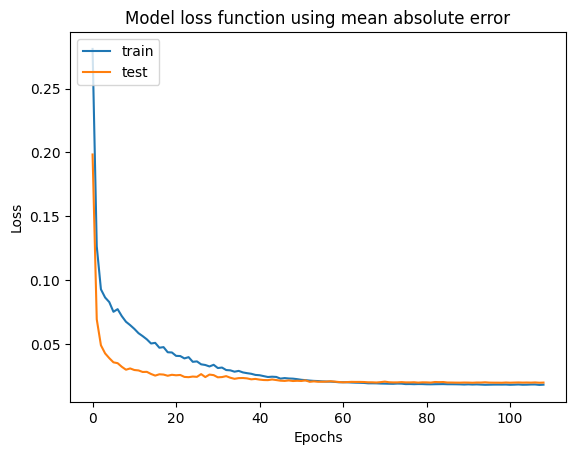

In [291]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_mae = keras.models.Sequential()
model_mae.add(keras.layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
model_mae.add(keras.layers.Dense(64, activation='relu'))
model_mae.add(keras.layers.Dropout(0.25))  # Regularization
model_mae.add(keras.layers.Dense(1, activation='linear'))

model_mae.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training
history_mae = model_mae.fit(X_train_scaled, y_train, epochs=300, batch_size=16,
                            validation_data=(X_test_scaled, y_test), verbose=1,
                            callbacks=[early_stop])

# Plot
fig = plt.figure()
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title('Model loss function using mean absolute error')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [326]:
y_pred = model_mae.predict(X_test_scaled)
y_pred = y_pred.ravel()

#calcoliamo l'errore
mae = mean_absolute_error(y_test, y_pred)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)

print('mae', mae)
print('mape', mape)

5/5 [==============================] - 0s 3ms/step
mae 0.019779515694092656
mape 8.553215610190051


In [328]:
bls_price_nn = bls(X_test['s0'],
                   X_test['strike'],
                   y_pred,
                   0.004,
                   X_test['ttm'])

error = 100*(abs(X_test['price'] - bls_price_nn)/X_test['price'])
error.mean()

3.126492752316856

In [ ]:
ciao